# 第5章: 係り受け解析
日本語Wikipediaの「人工知能」に関する記事からテキスト部分を抜き出したファイルがai.ja.zipに収録されている． この文章をCaboChaやKNP等のツールを利用して係り受け解析を行い，その結果をai.ja.txt.parsedというファイルに保存せよ．このファイルを読み込み，以下の問に対応するプログラムを実装せよ．

In [4]:
! sed 's/\r$//g' data/ai.ja.txt | cabocha > data/ai.ja.txt.parsed

'sed' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [15]:
!ginza -f cabocha data/ai.ja.txt > data/ai.ja.txt.parsed

### 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，係り受け解析の結果（ai.ja.txt.parsed）を読み込み，各文をMorphオブジェクトのリストとして表現し，冒頭の説明文の形態素列を表示せよ．

In [22]:
class Morph:
    def __init__(self, morpheme):
        surface, morphemes, _ = morpheme.split("\t")
        morphemes = morphemes.split(",")
        self.surface = surface
        self.base = morphemes[6]
        self.pos = morphemes[0]
        self.pos1 = morphemes[1]
        if morphemes[2] == "サ変可能":
            self.application_type = True
        else:
            self.application_type = False
        
sen_morphemes = []
morphemes = []

path = "data/ai.ja.txt.parsed"
with open(path, "r",encoding="utf-8") as f:
    for line in f:
        #print(line)
        if line[0] == "*" or line == "\n":
            continue
        elif line == "EOS\n":
            sen_morphemes.append(morphemes)
            morphemes = []
            continue
        morphemes.append(Morph(line))
        #print(morphemes)
for i in sen_morphemes[1]:
    print(vars(i))

{'surface': '人工知能', 'base': '人工知能', 'pos': '名詞', 'pos1': '普通名詞', 'application_type': False}
{'surface': '（', 'base': '（', 'pos': '補助記号', 'pos1': '括弧開', 'application_type': False}
{'surface': 'じん', 'base': 'じん', 'pos': '名詞', 'pos1': '普通名詞', 'application_type': False}
{'surface': 'こうち', 'base': 'こうち', 'pos': '名詞', 'pos1': '普通名詞', 'application_type': False}
{'surface': 'のう', 'base': 'のう', 'pos': '助詞', 'pos1': '終助詞', 'application_type': False}
{'surface': '、', 'base': '、', 'pos': '補助記号', 'pos1': '読点', 'application_type': False}
{'surface': '、', 'base': '、', 'pos': '補助記号', 'pos1': '読点', 'application_type': False}
{'surface': 'AI', 'base': 'AI', 'pos': '名詞', 'pos1': '普通名詞', 'application_type': False}
{'surface': '〈', 'base': '〈', 'pos': '補助記号', 'pos1': '括弧開', 'application_type': False}
{'surface': 'エーアイ', 'base': 'エーアイ', 'pos': '名詞', 'pos1': '固有名詞', 'application_type': False}
{'surface': '〉', 'base': '〉', 'pos': '補助記号', 'pos1': '括弧閉', 'application_type': False}
{'surface': '）', 'base': ')', 

### 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストの係り受け解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，冒頭の説明文の文節の文字列と係り先を表示せよ．本章の残りの問題では，ここで作ったプログラムを活用せよ．

In [71]:
class Chunk:
    def __init__(self, morphs, dst, chunk_num):
        self.morphs = morphs
        self.dst = int(dst[:-1])
        self.srcs = []
        self.chunk_num = chunk_num
        
    def noun_masked_surface(self, mask, dst=False):
        '''名詞を指定文字(mask)でマスクした表層形を返す
        dstがTrueの場合は最左の名詞をマスクした以降は切り捨てて返す

        戻り値：
        名詞をマスクした表層形
        '''
        result = ''
        for morph in self.morphs:
            if morph.pos != '記号':
                if morph.pos == '名詞':
                    result += mask
                    if dst:
                        return result
                    mask = ''       # 最初に見つけた名詞をマスク、以降の名詞は除去
                else:
                    result += morph.surface
        return result
    
    def normalized_surface(self):
        '''句読点などの記号を除いた表層形'''
        result = ''
        for morph in self.morphs:
            if morph.pos != '記号':
                result += morph.surface
        return result
        
chunk_flag = False
morphs = []
Chunks = []
Sentence = []

with open(path, "r", encoding="utf-8") as f:
    for line in f:
        if line == "\n":
            continue
        if line[0] == "*":
            if chunk_flag:
                Chunks.append(Chunk(morphs, dst, chunk_num))
                morphs = []
            else:
                chunk_flag = True
            dst = line.split()[2]
            chunk_num = int(line.split()[1])
        elif line == "EOS\n":
            Chunks.append(Chunk(morphs, dst, chunk_num))
            Sentence.append(Chunks)
            Chunks = []
            morphs = []
            chunk_flag = False
        else:
            morphs.append(Morph(line))
# 係り先-1は係り先なし
# Sentenceでは文章区切り、その中にChunks区切り、その中に各チャンク 
"""Sen[
        Chunks[
            Chunk{morphs,dst,srcs[],chunk_num},
            Chunk,
            ],
        Chunks[
            Chunk,
            Chunk,
            ]
       ]
"""

for chunks in Sentence:
    for i in chunks:
        if i.dst == "-1":
            continue
        else:
            from_num = i.chunk_num
            to_num = i.dst
            #print(from_num, to_num)
            chunks[int(to_num)].srcs.append(from_num)

chunks = Sentence[1]
for i in chunks:
    if i.dst != "-1D":
        print(i.chunk_num, "from", i.srcs, "to", i.dst)
    else:
        print(i.chunk_num, "from", i.srcs, "to None",)
    for l in i.morphs:
        print(l.surface, end="")
    print('')
print("EOS")

0 from [] to 1
人工知能（じんこうちのう、、AI〈エーアイ〉）とは、「『計算（）』という
1 from [0] to 2
概念と
2 from [1] to 3
『コンピュータ（）』という
3 from [2] to 4
道具を
4 from [3] to 6
用いて
5 from [] to 6
『知能』を
6 from [4, 5] to 7
研究する
7 from [6] to 8
計算機科学（）の一分野」を
8 from [7] to 9
指す
9 from [8, 9] to -1
語。
EOS


## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [10]:
f = open("data/42ans.txt","w", encoding="utf-8")
for chunks in Sentence:
    for i in chunks:
        if i.dst and i.dst != "-1D":
            ans = ""
            for l in i.morphs:
                ans += l.surface
            to = i.dst[:-1]
            to_chunk = chunks[int(to)]
            #print("\t", end="")
            for l in to_chunk.morphs:
                ans += l.surface
            ans += "\n"
            f.write(ans)
f.close()

In [11]:
!cat data/42ans.txt | head -n 10

'cat' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [12]:
f = open("data/43ans.txt","w", encoding="utf-8")
import string
for chunks in Sentence:
    for i in chunks:
        noun = False
        vorb = False
        for morph in i.morphs:
            if morph.pos == "名詞":
                noun = True
        if noun:
            to =i.dst[:-1]
            to_chunk = chunks[int(to)]
            for morph in to_chunk.morphs:
                if morph.pos == "動詞":
                    vorb = True
        if noun and vorb:
            for morph in i.morphs:
                if morph.pos1 == "句点" or morph.pos1 == "読点":
                    continue
                f.write(morph.surface.translate(str.maketrans('', '', string.punctuation))+"\n")
            print("\t",end="")
            for morph in to_chunk.morphs:
                if morph.pos1 == "句点" or morph.pos1 == "読点":
                    continue
                f.write(morph.surface.translate(str.maketrans('', '', string.punctuation))+"\n")
        noun = False
        vorb = False
f.close()

In [19]:
!cat data/43ans.txt | head -n 10

概念
と
『
コンピュータ
（
）
』
と
いう
道具


## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，Graphviz等を用いるとよい．

In [80]:
from graphviz import Graph
from graphviz import Digraph

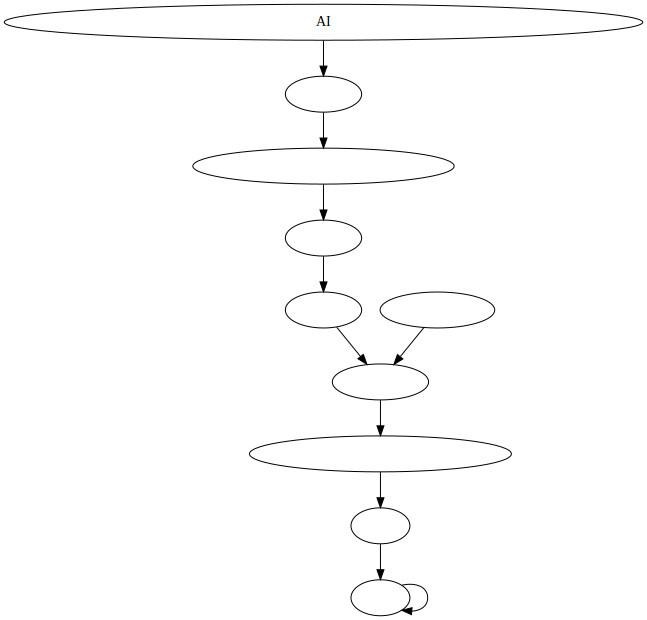

In [81]:
tree = Digraph(format='png')
chunks = Sentence[1]
for i in chunks:
    chunk_sen = ""
    for morph in i.morphs:
        chunk_sen += morph.surface
    to = int(i.dst[:-1])
    to_chunk = chunks[to]
    to_chunk_sen = ""
    for morph in to_chunk.morphs:
        to_chunk_sen += morph.surface
    if not tree.node(chunk_sen):
        tree.node(chunk_sen)
    if not tree.node(to_chunk_sen):
        tree.node(to_chunk_sen)
    tree.edge(chunk_sen, to_chunk_sen)
tree

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

動詞を含む文節において，最左の動詞の基本形を述語とする
述語に係る助詞を格とする
述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

作り出す	で は を
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

コーパス中で頻出する述語と格パターンの組み合わせ
「行う」「なる」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [13]:
file = open("data/prob45.txt", "w", encoding="utf-8")
for chunks in Sentence:
    for chunk in chunks:
        to_dict = dict()
        for morph in chunk.morphs:
            if morph.pos == "助詞":
                to = int(chunk.dst[:-1])
                to_chunk = chunks[to]
                #print(morph.base)
                for to_morph in to_chunk.morphs:
                    if to_morph.pos == "動詞":
                        #print(to_morph.base)
                        if not to_morph.base in to_dict:
                            to_dict[to_morph.base] = [morph.base]
                            
                        else:
                            k= to_dict[to_morph.base]
                            k.append(morph.base)
                            to_dict[to_morph.base] = k
        for key,value in to_dict.items():
            value.sort()
            comb = key + "\t" + "\t".join(value) +"\n"
            file.write(comb)
            #print(key, value)
            #print(comb)

In [83]:
!cat data/prob45.txt | sort | uniq -c | sort -nr | head -n 10

 100 する	を
  61 する	が
  58 いる	て
  49 する	に
  48 する	て
  30 する	は
  27 する	と
  27 する	で
  27 いる	が
  20 いる	を


In [84]:
!cat data/prob45.txt | grep "行う" | sort | uniq -c | sort -nr | head -n 10

  12 行う	を
   6 行う	に
   6 行う	て
   3 行う	は
   3 行う	で
   3 行う	が
   2 行う	に	は
   1 行う	まで
   1 行う	など
   1 行う	の


In [85]:
!cat data/prob45.txt | grep "なる" | sort | uniq -c | sort -nr | head -n 10

  11 なる	と
   9 なる	に
   9 なる	が
   7 なる	は
   7 なる	て
   3 なる	から
   3 なる	に	は
   2 なる	で
   1 無くなる	は
   1 異なる	で


In [86]:
!cat data/prob45.txt | grep "与える" | sort | uniq -c | sort -nr | head -n 10

   2 与える	が
   1 与える	など	に


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． この文は「作り出す」という１つの動詞を含み，「作り出す」に係る文節は「ジョン・マッカーシーは」，「会議で」，「用語を」であると解析された場合は，次のような出力になるはずである．

In [14]:
f = open("data/46ans.txt","w", encoding="utf-8")
for chunks in Sentence:
    for chunk in chunks:
        chunk_list = []
        to_dict = dict()
        for morph in chunk.morphs:
            chunk_list.append(morph.surface)
            if morph.pos == "助詞":
                to = int(chunk.dst[:-1])
                to_chunk = chunks[to]
                #print(morph.base)
                for to_morph in to_chunk.morphs:
                    if to_morph.pos == "動詞":
                        #print(to_morph.base)
                        if not to_morph.base in to_dict:
                            to_dict[to_morph.base] = [[morph.base],["".join(chunk_list)]]
                            chunk_list = []
                            
                        else:
                            k= to_dict[to_morph.base][0]
                            j= to_dict[to_morph.base][1]
                            k.append(morph.base)
                            j.append("".join(chunk_list))
                            chunk_list = []
                            to_dict[to_morph.base] = [k,j]
        for key,value in to_dict.items():
            value[0].sort()
            comb = key + "\t" + "\t".join(value[0]) + "\t" + "\t".join(value[1])  +"\n"
            f.write(comb)
            #print(key, value)
            #print(comb)
f.close()

In [21]:
!cat data/46ans.txt | head -n 10

いう	と	概念と
用いる	を	道具を
する	て	用いて
する	を	『知能』を
指す	の	を	計算機科学（）の	一分野」を
代わる	を	知的行動を
代わる	に	人間に
行う	て	代わって
行う	に	コンピューターに
する	は	または
cat: stdout: Broken pipe


## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）
例えば「また、自らの経験を元に学習を行う強化学習という手法もある。」という文から，以下の出力が得られるはずである．

学習を行う	に を	元に 経験を

In [109]:
for chunks in Sentence[:20]:
    for chunk in chunks:
        sahen_flag = False
        chunk_list = []
        to_dict = dict()
        for morph in chunk.morphs:
            chunk_list.append(morph.surface)
            if morph.pos == "名詞" and morph.application_type:
                sahen_flag = True
                noun = morph.base
            if morph.pos == "助詞":
                to = int(chunk.dst[:-1])
                to_chunk = chunks[to]
                #print(morph.base)
                for to_morph in to_chunk.morphs:
                    if to_morph.pos == "動詞":
                        #print(to_morph.base)
                        if sahen_flag:
                            if not to_morph.base in to_dict:
                                to_dict[to_morph.base] = [[morph.base],["".join(chunk_list)], noun]
                                chunk_list = []
                            
                            else:
                                k= to_dict[to_morph.base][0]
                                j= to_dict[to_morph.base][1]
                                k.append(morph.base)
                                j.append("".join(chunk_list))
                                chunk_list = []
                                to_dict[to_morph.base] = [k,j,noun]
        for key,value in to_dict.items():
            value[0].sort()
            comb = value[2] + "を" +key + "\t" + "\t".join(value[0]) + "\t" + "\t".join(value[1])
            #file.write(comb)
            #print(key, value)
            print(comb)

行動を代わる	を	知的行動を
設計を関する	や	設計や
研究をする	と	も	研究分野」と	も
解説を述べる	で	解説で
解説をいる	で	
判断をする	を	推論・判断を
解析をする	て	解析して
抽出をする	たり	検出・抽出したり
認識をある	が	画像認識等が
会議をする	で	ダートマス会議で
処理を用いる	を	記号処理を
記述をする	を	記述を
研究をいう	で	の	研究で	の
思考を呼ぶ	も	思考ルーチンも
思考をある	も	
プログラムを出す	が	プログラム（人工無脳）が
実現をなる	は	実現は
記述をなる	が	記述が
利用をする	が	利用が
利用をいる	が	
実現をする	の	へ	実現へ	の
アプローチを知る	て	と	は	アプローチと	して	は
アプローチをいる	て	と	は			
アプローチを知る	も	アプローチも
アプローチをいる	も	
明示をある	に	記号的明示性に
サポートを集める	が	「サポートベクターマシン」が
注目を集める	を	注目を
学習を行う	を	学習を
登場をよる	と	登場と
登場を行く	に	登場に
流行を超える	を	流行を
浸透を行く	て	浸透して
到達をなる	など	到達するなど
ものをある	が	ものが
計算をする	は	計算知能（CI）は
計算をいる	は	
学習を繰り返す	を	学習を
調整をする	の	している（例えば、パラメータ調整、コネクショニズムの
調整をいる	の	
学習をある	は	学習は
経験を基づく	に	経験に
関係をする	て	関係して
関係をいる	て	
ものをある	が	ものが


## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

各文節は（表層形の）形態素列で表現する
パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

ジョンマッカーシーは -> 作り出した
AIに関する -> 最初の -> 会議で -> 作り出した
最初の -> 会議で -> 作り出した
会議で -> 作り出した
人工知能という -> 用語を -> 作り出した
用語を -> 作り出した
KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．

ジョンマッカーシーは -> 作り出した
ＡＩに -> 関する -> 会議で -> 作り出した
会議で -> 作り出した
人工知能と -> いう -> 用語を -> 作り出した
用語を -> 作り出した

In [107]:
def func_tree(to,chunks):
    if len(chunks) <= to:
        return
    to_chunk = chunks[to]
    print(" -> ", end="")
    for to_morph in to_chunk.morphs:
        print(to_morph.surface, end="")
    to = int(to_chunk.dst[:-1])
    if to != -1:
        func_tree(to, chunks)
    else:
        return
    

for chunk in Sentence[33]:
    to_dict = dict()
    noun_flag = False
    for morph in chunk.morphs:
        if morph.pos == "名詞":
            to = int(chunk.dst[:-1])
            noun_flag = True
    if noun_flag:
        for morph in chunk.morphs:
            print(morph.surface, end="")
        if to!= -1:
                func_tree(to,Sentence[33])
                print()

ジョン・マッカーシーは -> 作り出した。
AIに関する -> 会議で -> 作り出した。
最初の -> 会議で -> 作り出した。
会議で -> 作り出した。
「人工知能」という -> 用語を -> 作り出した。
用語を -> 作り出した。


## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がi
とj
（i<j
）のとき，係り受けパスは以下の仕様を満たすものとする．

問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
文節i
とj
に含まれる名詞句はそれぞれ，XとYに置換する
また，係り受けパスの形状は，以下の2通りが考えられる．

文節i
から構文木の根に至る経路上に文節j
が存在する場合: 文節i
から文節j
のパスを表示
上記以外で，文節i
と文節j
から構文木の根に至る経路上で共通の文節k
で交わる場合: 文節i
から文節k
に至る直前のパスと文節j
から文節k
に至る直前までのパス，文節k
の内容を” | “で連結して表示
「ジョン・マッカーシーはAIに関する最初の会議で人工知能という用語を作り出した。」という例文を考える． CaboChaを係り受け解析に用いた場合，次のような出力が得られると思われる．

Xは | Yに関する -> 最初の -> 会議で | 作り出した
Xは | Yの -> 会議で | 作り出した
Xは | Yで | 作り出した
Xは | Yという -> 用語を | 作り出した
Xは | Yを | 作り出した
Xに関する -> Yの
Xに関する -> 最初の -> Yで
Xに関する -> 最初の -> 会議で | Yという -> 用語を | 作り出した
Xに関する -> 最初の -> 会議で | Yを | 作り出した
Xの -> Yで
Xの -> 会議で | Yという -> 用語を | 作り出した
Xの -> 会議で | Yを | 作り出した
Xで | Yという -> 用語を | 作り出した
Xで | Yを | 作り出した
Xという -> Yを
KNPを係り受け解析に用いた場合，次のような出力が得られると思われる．

Xは | Yに -> 関する -> 会議で | 作り出した。
Xは | Yで | 作り出した。
Xは | Yと -> いう -> 用語を | 作り出した。
Xは | Yを | 作り出した。
Xに -> 関する -> Yで
Xに -> 関する -> 会議で | Yと -> いう -> 用語を | 作り出した。
Xに -> 関する -> 会議で | Yを | 作り出した。
Xで | Yと -> いう -> 用語を | 作り出した。
Xで | Yを | 作り出した。
Xと -> いう -> Yを

In [113]:
# 結果ファイル作成
with open("data/49ans.txt", mode='w') as f:

    # 1文ずつリスト作成
    for chunks in Sentence:
        indexs_noun = []
        for chunk in chunks:
            # 名詞を含むchunkに限定した、chunksにおけるインデックスのリストを作成
            for morph in chunk.morphs:
                if morph.pos == "名詞":
                    indexs_noun.append(chunk.chunk_num)
                # 2つ以上ある？
        if len(indexs_noun) < 2:
            continue
        # 名詞を含むchunkの組み合わせを総当りでチェック
        for i, index_x in enumerate(indexs_noun[:-1]):
            for index_y in indexs_noun[i + 1:]:
                meet_y = False          # Yにぶつかった？
                index_dup = -1          # XとYの経路がぶつかったchunkのindex
                routes_x = set()        # Xの経路チェック用
                # 名詞Xから根に向かって、Yにぶつからないか調べながら探索
                dst = chunks[index_x].dst
                while dst != -1:
                    if dst == index_y:
                        meet_y = True           # Yにぶつかった
                        break
                    routes_x.add(dst)           # 経路チェックのために保存
                    dst = chunks[dst].dst
                # 名詞Yから根まで、Xの経路にぶつからないか調べながら探索
                if not meet_y:
                    dst = chunks[index_y].dst
                    while dst != -1:
                        if dst in routes_x:
                            index_dup = dst     # Xの経路とぶつかった
                            break
                        else:
                            dst = chunks[dst].dst
                # 結果出力
                if index_dup == -1:
                    # XからYにぶつかるパターン
                    f.write(chunks[index_x].noun_masked_surface('X'))
                    dst = chunks[index_x].dst
                    while dst != -1:
                        if dst == index_y:
                            f.write(
                                    ' -> ' + chunks[dst].noun_masked_surface('Y', True))
                            break
                        else:
                            f.write(
                                    ' -> ' + chunks[dst].normalized_surface())
                        dst = chunks[dst].dst
                    f.write('\n')
                else:
                    # 経路上の共通のchunkでぶつかるパターン
                    # Xからぶつかる手前までを出力
                    f.write(chunks[index_x].noun_masked_surface('X'))
                    dst = chunks[index_x].dst
                    while dst != index_dup:
                        f.write(' -> ' + chunks[dst].normalized_surface())
                        dst = chunks[dst].dst
                    f.write(' | ')
                    # Yからぶつかる手前までを出力
                    f.write(chunks[index_y].noun_masked_surface('Y'))
                    dst = chunks[index_y].dst
                    while dst != index_dup:
                        f.write(' -> ' + chunks[dst].normalized_surface())
                        dst = chunks[dst].dst
                    f.write(' | ')
                    # ぶつかったchunkを出力
                    f.write(chunks[index_dup].normalized_surface())
                    f.write('\n')

In [115]:
!cat data/49ans.txt | tail -n 10

Xから -> 監視する -> 政府支援の -> プロジェクトが -> 推し進められ、 -> 行わせ、 -> 顔認識 -> Y

Xらは、 | Yの -> 軍事利用により -> 加速すると | 主張している。

Xが -> 不可能な -> Y

Xに | Yは | 採択するも

Xなど -> 拡散させて -> 攻撃する -> ドローン兵器も -> Y

